In [18]:
# ==============================================================================
# LEGO QUALITÄTSKONTROLLE - FINALES PYTORCH-SKRIPT
# ==============================================================================
# Dieses Skript implementiert den gesamten Workflow für die Konzeption,
# das Training und die Evaluation eines Deep-Learning-Modells zur
# visuellen Qualitätskontrolle von LEGO-Modellen mittels Transfer Learning.
#
# Workflow:
# 1. Setup & Konfiguration: Definition aller Pfade und Hyperparameter.
# 2. Daten-Pipeline: Laden und Vorverarbeiten der Bilddaten.
# 3. Modell-Definition: Laden und Anpassen eines vortrainierten Modells.
# 4. Training: Implementierung der Trainings- und Validierungsschleife.
# 5. Evaluation & Visualisierung: Analyse der Ergebnisse.
# ==============================================================================


# ------------------------------------------------------------------------------
# 1. SETUP & IMPORTS
# ------------------------------------------------------------------------------
import os
import random
import json
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from timm.models import create_model
from torchinfo import summary
from torchmetrics import MeanMetric, Accuracy, F1Score, Precision, Recall, ConfusionMatrix

from codecarbon import EmissionsTracker
import pkbar

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [19]:
# ------------------------------------------------------------------------------
# 2. GLOBALE KONFIGURATION & REPRODUZIERBARKEIT
# ------------------------------------------------------------------------------

# -- Reproduzierbarkeit --
# Setzt den "Seed" für alle Zufallsgeneratoren, um bei jedem Lauf die gleichen
# Ergebnisse zu erzielen. Wichtig für wissenschaftliche Arbeiten.
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
# Erzwingt deterministische Algorithmen, kann aber langsamer sein.
# Für den finalen, dokumentierten Lauf aktivieren.
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# -- Pfad-Management --
# Definiert eine saubere, relative Projektstruktur.
# Annahme: Dieses Notebook liegt in einem 'notebooks'-Ordner.
# LEGO_Project/
#  |- data/
#  |- models/
#  |- notebooks/
#      |- dieses_notebook.ipynb
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
MODEL_DIR = os.path.join(ROOT_DIR, "models")
DATA_DIR = os.path.join(ROOT_DIR, "data")
os.makedirs(MODEL_DIR, exist_ok=True)

TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

print("Projekt-Pfade:")
print(f"Root: {ROOT_DIR}")
print(f"Daten: {DATA_DIR}")
print(f"Modelle: {MODEL_DIR}")

# -- Hyperparameter --
BATCH_SIZE = 32
IMAGE_SIZE = 224
PRE_CROPPED_SIZE = 256 # Für die RandomCrop-Augmentierung
LEARN_RATE = 5e-5      # Kleine Lernrate für Transfer Learning
NUM_EPOCHS = 20        # Anzahl der Epochen für Entwicklungs-Läufe

# -- ImageNet-Statistiken für die Normalisierung --
# Diese Werte sind für alle auf ImageNet vortrainierten Modelle obligatorisch.
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

Projekt-Pfade:
Root: /myraid/LEGO_Project
Daten: /myraid/LEGO_Project/data
Modelle: /myraid/LEGO_Project/models


In [20]:
# ------------------------------------------------------------------------------
# 3. DATEN-PIPELINE
# ------------------------------------------------------------------------------
print("\n[INFO] Erstelle Daten-Pipeline...")

# -- Transformationen --
# Starke Augmentierungs-Pipeline für das Training, um das Modell robuster zu machen.
train_transforms = transforms.Compose([
    transforms.Resize((PRE_CROPPED_SIZE, PRE_CROPPED_SIZE)),
    transforms.RandomCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Minimale, deterministische Transformationen für Validierung und Test.
# Keine Augmentierung, um Ergebnisse vergleichbar zu machen.
eval_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# -- Datasets --
# ImageFolder liest automatisch Bilder aus Ordnern, deren Namen als Klassen-Label dienen.
train_dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=train_transforms)
valid_dataset = ImageFolder(root=VALID_DATA_DIR, transform=eval_transforms)
try:
    test_dataset = ImageFolder(root=TEST_DATA_DIR, transform=eval_transforms)
except FileNotFoundError:
    print(f"[WARNUNG] Test-Verzeichnis nicht gefunden unter '{TEST_DATA_DIR}'. Evaluation wird übersprungen.")
    test_dataset = None

# -- Dynamische Variablen aus den Daten ableiten --
CLASSES = train_dataset.classes
NUM_CLASSES = len(CLASSES)
print(f"Klassen gefunden ({NUM_CLASSES}): {CLASSES}")

# -- Sampler für Entwicklungs-Läufe --
# Wählt eine zufällige Teilmenge (hier 50%) der Trainingsdaten aus, um das
# Experimentieren zu beschleunigen. Für den finalen Lauf auskommentieren.
indices = list(range(len(train_dataset)))
np.random.shuffle(indices)
split = int(np.floor(0.5 * len(train_dataset)))
train_sampler = SubsetRandomSampler(indices[:split])

# -- DataLoaders --
# Bereiten die Daten in Batches für das Training vor.
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=4, pin_memory=True)
# Für den finalen Lauf:
# train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
if test_dataset:
    test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Trainings-Samples in diesem Lauf: {len(train_loader.sampler)}")
print(f"Validierungs-Samples: {len(valid_dataset)}")
if test_dataset:
    print(f"Test-Samples: {len(test_dataset)}")


[INFO] Erstelle Daten-Pipeline...
Klassen gefunden (4): ['blaue_auto', 'blume_erwin', 'ente_henry', 'rote_auto']
Trainings-Samples in diesem Lauf: 106
Validierungs-Samples: 52
Test-Samples: 52


In [21]:
# ------------------------------------------------------------------------------
# 4. MODELL-DEFINITION (TRANSFER LEARNING)
# ------------------------------------------------------------------------------
print("\n[INFO] Erstelle Modell für Transfer Learning...")

# -- Modell laden und anpassen --
# Wir wählen 'efficientnet_b2' als effizienten und leistungsstarken Kompromiss.
model = create_model(
    model_name="efficientnet_b2",
    pretrained=True,
    num_classes=1000  # Zuerst mit originalem Kopf laden
)

# -- Gewichte einfrieren (Feature Extraction) --
# Alle vortrainierten Gewichte werden eingefroren.
for param in model.parameters():
    param.requires_grad = False

# -- Klassifikator ersetzen --
# Nur der neue Kopf wird trainierbar sein.
num_in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, NUM_CLASSES)
)

# -- Modell-Zusammenfassung --
summary_info = summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE), verbose=0)
print(summary_info)
print(f"Trainierbare Parameter: {summary_info.trainable_params:,} ({100 * summary_info.trainable_params / summary_info.total_params:.2f}%)")



[INFO] Erstelle Modell für Transfer Learning...
Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [32, 4]                   --
├─Conv2d: 1-1                                 [32, 32, 112, 112]        (864)
├─BatchNormAct2d: 1-2                         [32, 32, 112, 112]        64
│    └─Identity: 2-1                          [32, 32, 112, 112]        --
│    └─SiLU: 2-2                              [32, 32, 112, 112]        --
├─Sequential: 1-3                             [32, 352, 7, 7]           --
│    └─Sequential: 2-3                        [32, 16, 112, 112]        --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 16, 112, 112]        (1,448)
│    │    └─DepthwiseSeparableConv: 3-2       [32, 16, 112, 112]        (612)
│    └─Sequential: 2-4                        [32, 24, 56, 56]          --
│    │    └─InvertedResidual: 3-3             [32, 24, 56, 56]          (6,004)
│    │    └─InvertedResidual: 

In [22]:
# ------------------------------------------------------------------------------
# 5. TRAINING SETUP (OPTIMIERER, SCHEDULER, METRIKEN)
# ------------------------------------------------------------------------------
print("\n[INFO] Konfiguriere Trainings-Setup...")

# -- Gerät wählen --
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Verwende Gerät: {device.upper()}")

# -- Optimierer --
# Adam ist ein robuster Standard-Optimierer. Wir übergeben ihm nur die
# Parameter unseres neuen, trainierbaren Klassifikators.
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARN_RATE)

# -- Learning Rate Scheduler --
# CosineAnnealingLR passt die Lernrate sanft über die Epochen an.
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# -- Metriken --
# Wir definieren separate Metrik-Objekte für Training und Validierung.
train_loss_metric = MeanMetric().to(device)
train_accuracy_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
train_f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)

val_loss_metric = MeanMetric().to(device)
val_accuracy_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
val_f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
val_precision_metric = Precision(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)
val_recall_metric = Recall(task="multiclass", num_classes=NUM_CLASSES, average='macro').to(device)

# -- Logging --
# Ein Dictionary, um die Ergebnisse jeder Epoche zu speichern.
logs = {
    'loss': [], 'accuracy': [], 'f1_score': [],
    'val_loss': [], 'val_accuracy': [], 'val_f1_score': [],
    'val_precision': [], 'val_recall': []
}

# -- Modell & Scaler auf Gerät verschieben --
model.to(device)
# Automatic Mixed Precision (AMP) beschleunigt das Training auf GPUs.
scaler = torch.cuda.amp.GradScaler(enabled=(device == "cuda"))



[INFO] Konfiguriere Trainings-Setup...
Verwende Gerät: CUDA


In [23]:
# ------------------------------------------------------------------------------
# 6. TRAINING & EXPERIMENT-TRACKING
# ------------------------------------------------------------------------------

# -- Experiment-Ordner erstellen --
# Jeder Lauf wird in einem eigenen, zeitgestempelten Ordner gespeichert.
run_name = f"{datetime.now().strftime('%Y%m%d_%H%M')}_model-{model.default_cfg['architecture']}_lr-{LEARN_RATE}"
run_dir = os.path.join(MODEL_DIR, run_name)
os.makedirs(run_dir, exist_ok=True)
print(f"\n[INFO] Starte neuen Trainingslauf. Ergebnisse werden in '{run_dir}' gespeichert.")

# -- Konfiguration speichern --
config = {
    "run_name": run_name, "model_name": model.default_cfg['architecture'],
    "num_classes": NUM_CLASSES, "classes": CLASSES, "batch_size": BATCH_SIZE,
    "image_size": IMAGE_SIZE, "learning_rate": LEARN_RATE, "optimizer": type(optimizer).__name__,
    "scheduler": type(scheduler).__name__, "num_epochs": NUM_EPOCHS
}
with open(os.path.join(run_dir, 'config.json'), 'w') as f:
    json.dump(config, f, indent=4)

# -- Trainingsschleife --
best_val_loss = float('inf')
tracker = EmissionsTracker(output_dir=run_dir, project_name=run_name)
tracker.start()

try:
    for epoch in range(NUM_EPOCHS):
        # --- Trainings-Phase ---
        model.train()
        train_loss_metric.reset(); train_accuracy_metric.reset(); train_f1_metric.reset()
        kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=NUM_EPOCHS, width=25, always_stateful=True)
        
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.autocast(device_type=device, dtype=torch.float16, enabled=(device=="cuda")):
                outputs = model(images)
                loss = nn.CrossEntropyLoss()(outputs, labels) # Verlustfunktion direkt hier definieren
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss_metric.update(loss)
            train_accuracy_metric.update(outputs, labels)
            train_f1_metric.update(outputs, labels)
            kbar.update(i, values=[("loss", train_loss_metric.compute()), ("accuracy", train_accuracy_metric.compute())])

        # --- Validierungs-Phase ---
        model.eval()
        val_loss_metric.reset(); val_accuracy_metric.reset(); val_f1_metric.reset()
        val_precision_metric.reset(); val_recall_metric.reset()
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images)
                val_loss_metric.update(nn.CrossEntropyLoss()(outputs, labels))
                val_accuracy_metric.update(outputs, labels)
                val_f1_metric.update(outputs, labels)
                val_precision_metric.update(outputs, labels)
                val_recall_metric.update(outputs, labels)

        # --- Epochen-Ende: Logging & Checkpointing ---
        epoch_metrics = {
            'loss': train_loss_metric.compute().item(), 'accuracy': train_accuracy_metric.compute().item(),
            'f1_score': train_f1_metric.compute().item(), 'val_loss': val_loss_metric.compute().item(),
            'val_accuracy': val_accuracy_metric.compute().item(), 'val_f1_score': val_f1_metric.compute().item(),
            'val_precision': val_precision_metric.compute().item(), 'val_recall': val_recall_metric.compute().item()
        }
        for k, v in epoch_metrics.items(): logs[k].append(v)
        kbar.add(1, values=[("val_loss", epoch_metrics['val_loss']), ("val_accuracy", epoch_metrics['val_accuracy'])])
        scheduler.step()
        
        if epoch_metrics['val_loss'] < best_val_loss:
            best_val_loss = epoch_metrics['val_loss']
            torch.save(model.state_dict(), os.path.join(run_dir, 'best_model.pth'))
            print(f" Epoche {epoch+1}: Neuer bester val_loss: {best_val_loss:.4f}. Modell gespeichert.")

finally:
    tracker.stop()
    logs_df = pd.DataFrame(logs)
    logs_df.to_csv(os.path.join(run_dir, 'training_history.csv'), index_label='epoch')

print(f"\n✅ Training abgeschlossen. Bestes Modell und Logs gespeichert in: {run_dir}")

[codecarbon INFO @ 13:27:09] [setup] RAM Tracking...
[codecarbon INFO @ 13:27:09] [setup] GPU Tracking...
[codecarbon INFO @ 13:27:09] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:27:09] [setup] CPU Tracking...
[codecarbon WARNING @ 13:27:09] No CPU tracking mode found. Falling back on CPU constant mode.



[INFO] Starte neuen Trainingslauf. Ergebnisse werden in '/myraid/LEGO_Project/models/20250731_1327_model-efficientnet_b2_lr-5e-05' gespeichert.


[codecarbon WARNING @ 13:27:11] We saw that you have a Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 13:27:11] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
[codecarbon INFO @ 13:27:11] >>> Tracker's metadata:
[codecarbon INFO @ 13:27:11]   Platform system: Linux-5.15.0-1081-nvidia-x86_64-with-glibc2.35
[codecarbon INFO @ 13:27:11]   Python version: 3.12.11
[codecarbon INFO @ 13:27:11]   CodeCarbon version: 2.2.2
[codecarbon INFO @ 13:27:11]   Available RAM : 503.756 GB
[codecarbon INFO @ 13:27:11]   CPU count: 80
[codecarbon INFO @ 13:27:11]   CPU model: Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
[codecarbon INFO @ 13:27:11]   GPU count: 1
[codecarbon INFO @ 13:27:11]   GPU model: 1 x Tesla V100-SXM2-16GB


Epoch: 1/20
4/4 [=========================] - 1s 272ms/step - loss: 1.3722 - accuracy: 0.3181 - val_loss: 1.3798 - val_accuracy: 0.1099
 Epoche 1: Neuer bester val_loss: 1.3798. Modell gespeichert.
Epoch: 2/20
4/4 [=========================] - 1s 253ms/step - loss: 1.3156 - accuracy: 0.6033 - val_loss: 1.3482 - val_accuracy: 0.3159
 Epoche 2: Neuer bester val_loss: 1.3482. Modell gespeichert.
Epoch: 3/20
4/4 [=========================] - 1s 243ms/step - loss: 1.2800 - accuracy: 0.7298 - val_loss: 1.3147 - val_accuracy: 0.5236
 Epoche 3: Neuer bester val_loss: 1.3147. Modell gespeichert.
Epoch: 4/20
4/4 [=========================] - 1s 248ms/step - loss: 1.2342 - accuracy: 0.7949 - val_loss: 1.2765 - val_accuracy: 0.6793
 Epoche 4: Neuer bester val_loss: 1.2765. Modell gespeichert.
Epoch: 5/20
4/4 [=========================] - 1s 264ms/step - loss: 1.2040 - accuracy: 0.8581 - val_loss: 1.2415 - val_accuracy: 0.7594
 Epoche 5: Neuer bester val_loss: 1.2415. Modell gespeichert.
Epoch: 6/2

[codecarbon INFO @ 13:27:29] Energy consumed for RAM : 0.000787 kWh. RAM Power : 188.90841579437256 W
[codecarbon INFO @ 13:27:29] Energy consumed for all GPUs : 0.000451 kWh. Total GPU Power : 108.264 W
[codecarbon INFO @ 13:27:29] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:27:29] 0.001416 kWh of electricity used since the beginning.


4/4 [=========================] - 1s 261ms/step - loss: 0.9716 - accuracy: 0.9179 - val_loss: 1.0662 - val_accuracy: 0.9375
 Epoche 14: Neuer bester val_loss: 1.0662. Modell gespeichert.
Epoch: 15/20
4/4 [=========================] - 1s 256ms/step - loss: 1.0008 - accuracy: 0.9320 - val_loss: 1.0577 - val_accuracy: 0.9583
 Epoche 15: Neuer bester val_loss: 1.0577. Modell gespeichert.
Epoch: 16/20
4/4 [=========================] - 1s 252ms/step - loss: 0.9710 - accuracy: 0.9304 - val_loss: 1.0537 - val_accuracy: 0.9375
 Epoche 16: Neuer bester val_loss: 1.0537. Modell gespeichert.
Epoch: 17/20
4/4 [=========================] - 1s 249ms/step - loss: 0.9469 - accuracy: 0.9581 - val_loss: 1.0522 - val_accuracy: 0.9583
 Epoche 17: Neuer bester val_loss: 1.0522. Modell gespeichert.
Epoch: 18/20
4/4 [=========================] - 1s 276ms/step - loss: 0.9312 - accuracy: 0.9565 - val_loss: 1.0479 - val_accuracy: 0.9583
 Epoche 18: Neuer bester val_loss: 1.0479. Modell gespeichert.
Epoch: 19/20


[codecarbon INFO @ 13:27:36] Energy consumed for RAM : 0.001185 kWh. RAM Power : 188.90841579437256 W
[codecarbon INFO @ 13:27:36] Energy consumed for all GPUs : 0.000575 kWh. Total GPU Power : 58.876000000000005 W
[codecarbon INFO @ 13:27:36] Energy consumed for all CPUs : 0.000267 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 13:27:36] 0.002027 kWh of electricity used since the beginning.


 Epoche 20: Neuer bester val_loss: 1.0413. Modell gespeichert.

✅ Training abgeschlossen. Bestes Modell und Logs gespeichert in: /myraid/LEGO_Project/models/20250731_1327_model-efficientnet_b2_lr-5e-05


/home/endrit.murati001/.conda/envs/diffproml/lib/python3.12/site-packages/codecarbon/output.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])



[INFO] Erstelle finale Auswertung und Visualisierungen...


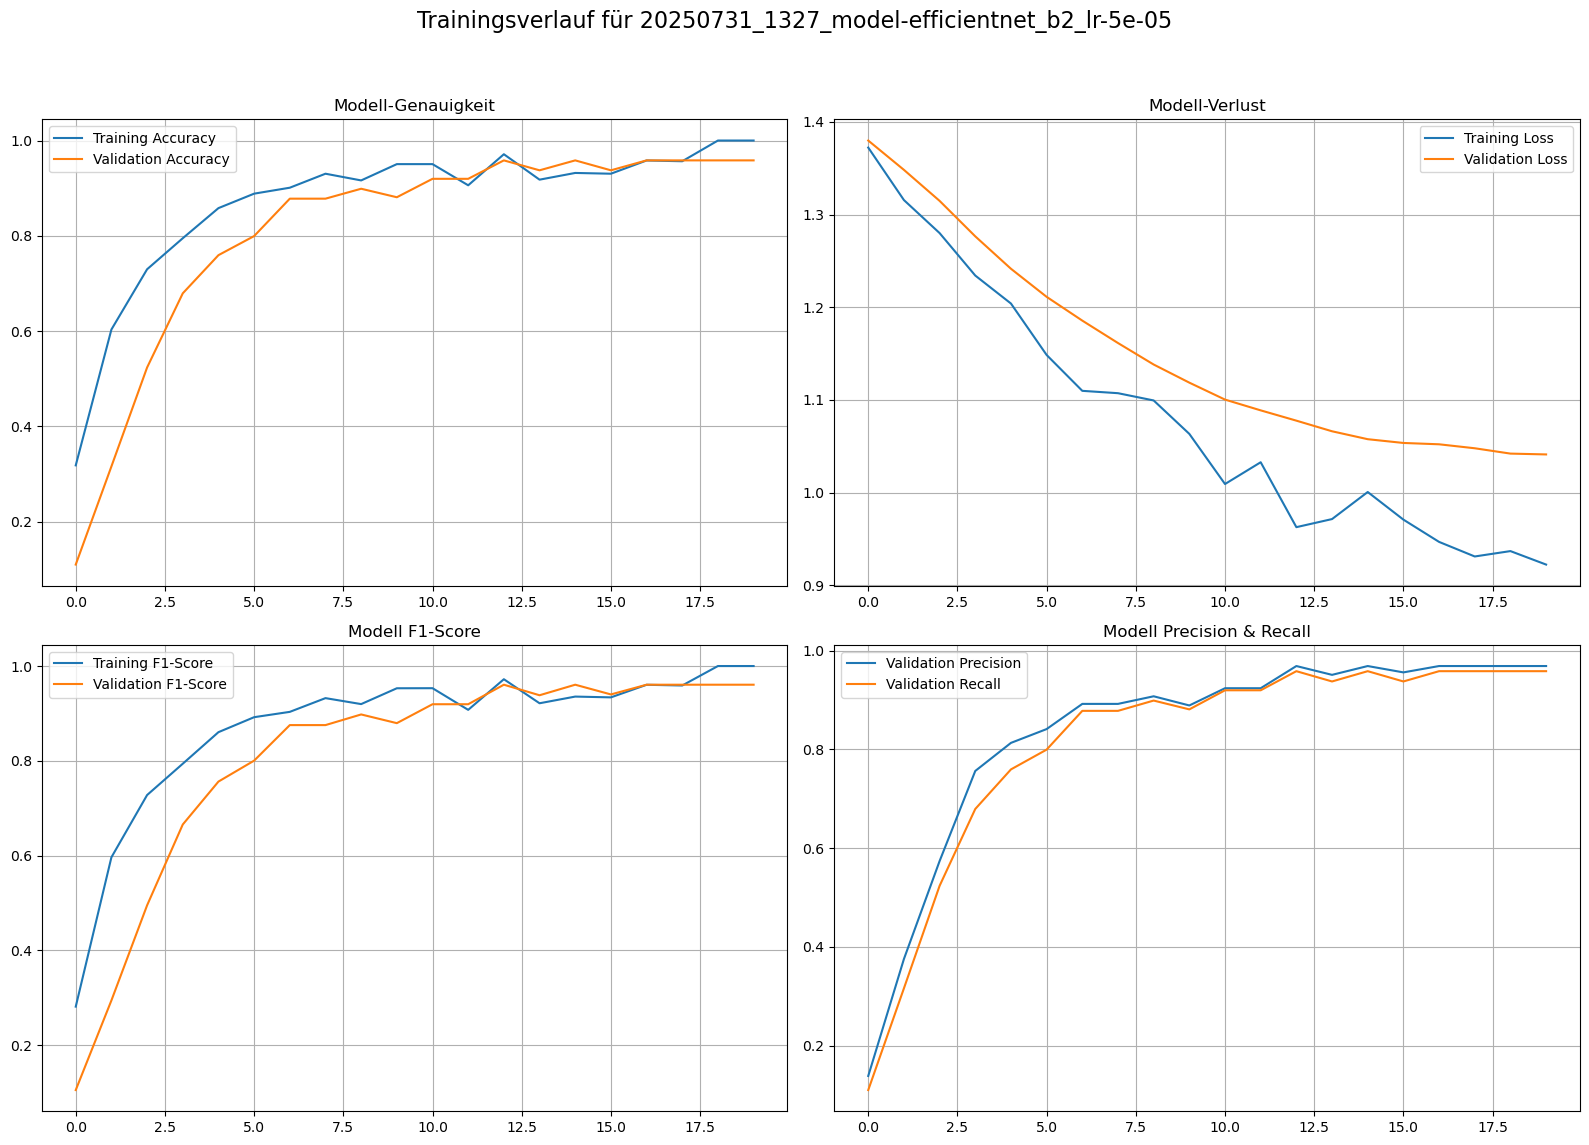


[INFO] Evaluiere bestes Modell auf dem unabhängigen Test-Set...
Finale Test-Genauigkeit: 0.9375
Finaler Test F1-Score: 0.9384


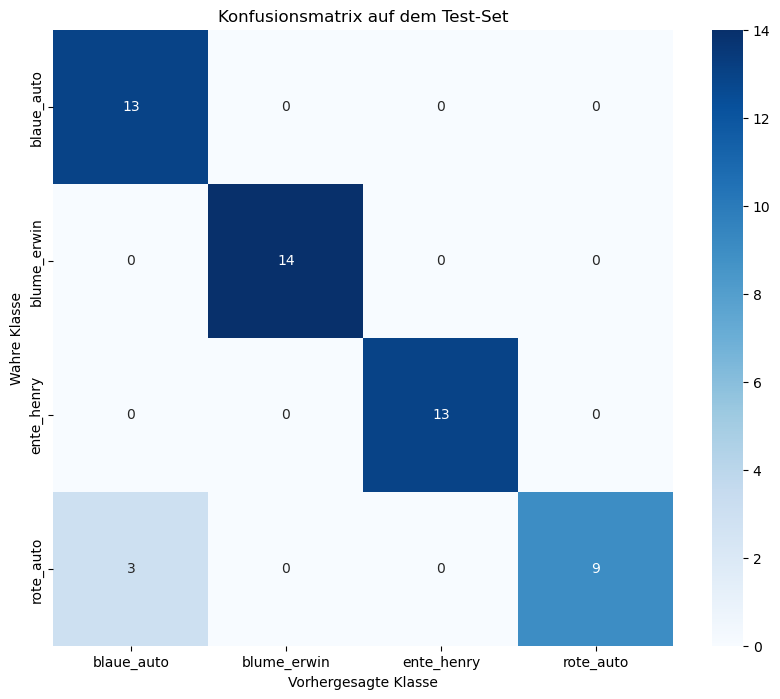


[INFO] Erstelle Grad-CAM Visualisierung...


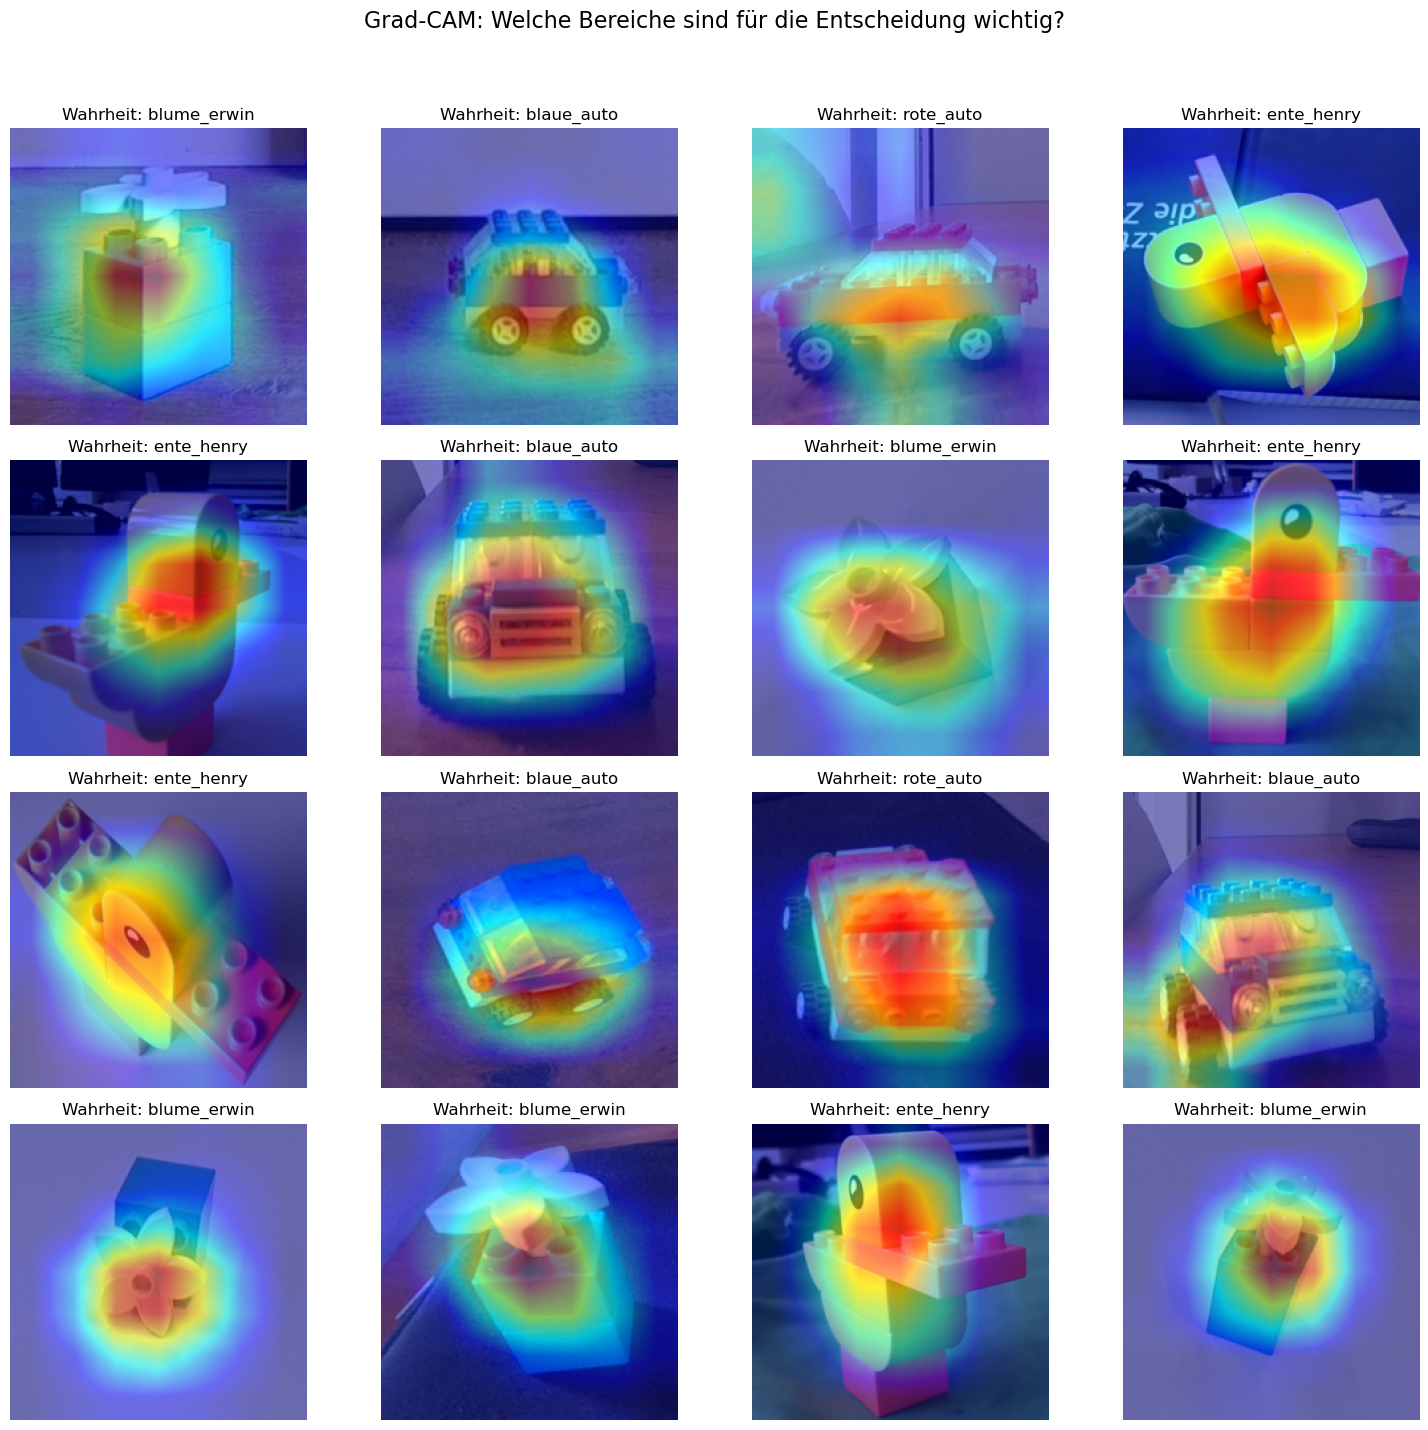


[INFO] Alle Schritte abgeschlossen.


In [24]:
# ------------------------------------------------------------------------------
# 7. VISUALISIERUNG & FINALE EVALUATION
# ------------------------------------------------------------------------------
print("\n[INFO] Erstelle finale Auswertung und Visualisierungen...")

# -- Lernkurven plotten --
logs_df = pd.read_csv(os.path.join(run_dir, 'training_history.csv'))
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Trainingsverlauf für {run_name}', fontsize=16)
ax[0, 0].plot(logs_df['accuracy'], label='Training Accuracy'); ax[0, 0].plot(logs_df['val_accuracy'], label='Validation Accuracy')
ax[0, 0].set_title('Modell-Genauigkeit'); ax[0, 0].legend(); ax[0, 0].grid(True)
ax[0, 1].plot(logs_df['loss'], label='Training Loss'); ax[0, 1].plot(logs_df['val_loss'], label='Validation Loss')
ax[0, 1].set_title('Modell-Verlust'); ax[0, 1].legend(); ax[0, 1].grid(True)
ax[1, 0].plot(logs_df['f1_score'], label='Training F1-Score'); ax[1, 0].plot(logs_df['val_f1_score'], label='Validation F1-Score')
ax[1, 0].set_title('Modell F1-Score'); ax[1, 0].legend(); ax[1, 0].grid(True)
ax[1, 1].plot(logs_df['val_precision'], label='Validation Precision'); ax[1, 1].plot(logs_df['val_recall'], label='Validation Recall')
ax[1, 1].set_title('Modell Precision & Recall'); ax[1, 1].legend(); ax[1, 1].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(run_dir, 'training_dashboard.png'))
plt.show()

# -- Evaluation auf dem Test-Set --
if test_dataset:
    print("\n[INFO] Evaluiere bestes Modell auf dem unabhängigen Test-Set...")
    # Lade das beste Modell
    model.load_state_dict(torch.load(os.path.join(run_dir, 'best_model.pth')))
    model.eval()

    # Metriken für den Test-Lauf
    test_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
    test_f1 = F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
    conf_matrix = ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES).to(device)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_accuracy.update(outputs, labels)
            test_f1.update(outputs, labels)
            conf_matrix.update(outputs, labels)

    print(f"Finale Test-Genauigkeit: {test_accuracy.compute().item():.4f}")
    print(f"Finaler Test F1-Score: {test_f1.compute().item():.4f}")

    # Konfusionsmatrix visualisieren
    cm = conf_matrix.compute().cpu().numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Vorhergesagte Klasse'); plt.ylabel('Wahre Klasse')
    plt.title('Konfusionsmatrix auf dem Test-Set')
    plt.savefig(os.path.join(run_dir, 'confusion_matrix.png'))
    plt.show()

# -- Grad-CAM Visualisierung --
def denormalization(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    img_tensor = img_tensor.clone()
    mean_tensor = torch.tensor(mean).view(3, 1, 1); std_tensor = torch.tensor(std).view(3, 1, 1)
    img_tensor.mul_(std_tensor).add_(mean_tensor)
    img_tensor = torch.clamp(img_tensor, 0, 1)
    return np.transpose(img_tensor.numpy(), (1, 2, 0))

print("\n[INFO] Erstelle Grad-CAM Visualisierung...")
if test_dataset:
    # KORREKTUR: Modell in den eval-Modus setzen und Gradienten aktivieren
    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    target_layers = [model.conv_head] # Korrekte Schicht für EfficientNet
    cam = GradCAM(model=model, target_layers=target_layers)
    
    vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
    images, labels = next(iter(vis_loader))
    images, labels = images.to(device), labels.to(device)
    
    grayscale_cam = cam(input_tensor=images, aug_smooth=True)
    
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    fig.suptitle('Grad-CAM: Welche Bereiche sind für die Entscheidung wichtig?', fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i >= len(images): ax.axis('off'); continue
        img_display = denormalization(images[i].cpu())
        cam_image = show_cam_on_image(img_display, grayscale_cam[i, :], use_rgb=True)
        ax.imshow(cam_image)
        ax.set_title(f"Wahrheit: {CLASSES[labels[i].item()]}")
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(run_dir, 'grad_cam_examples.png'))
    plt.show()

print("\n[INFO] Alle Schritte abgeschlossen.")

In [ ]:
# ------------------------------------------------------------------------------
# 7. VISUALISIERUNG & FINALE EVALUATION
# ------------------------------------------------------------------------------
print("\n[INFO] Erstelle finale Auswertung und Visualisierungen...")

# -- Lernkurven plotten --
logs_df = pd.read_csv(os.path.join(run_dir, 'training_history.csv'))
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Trainingsverlauf für {run_name}', fontsize=16)
ax[0, 0].plot(logs_df['accuracy'], label='Training Accuracy'); ax[0, 0].plot(logs_df['val_accuracy'], label='Validation Accuracy')
ax[0, 0].set_title('Modell-Genauigkeit'); ax[0, 0].legend(); ax[0, 0].grid(True)
ax[0, 1].plot(logs_df['loss'], label='Training Loss'); ax[0, 1].plot(logs_df['val_loss'], label='Validation Loss')
ax[0, 1].set_title('Modell-Verlust'); ax[0, 1].legend(); ax[0, 1].grid(True)
ax[1, 0].plot(logs_df['f1_score'], label='Training F1-Score'); ax[1, 0].plot(logs_df['val_f1_score'], label='Validation F1-Score')
ax[1, 0].set_title('Modell F1-Score'); ax[1, 0].legend(); ax[1, 0].grid(True)
ax[1, 1].plot(logs_df['val_precision'], label='Validation Precision'); ax[1, 1].plot(logs_df['val_recall'], label='Validation Recall')
ax[1, 1].set_title('Modell Precision & Recall'); ax[1, 1].legend(); ax[1, 1].grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(os.path.join(run_dir, 'training_dashboard.png'))
plt.show()

# -- Evaluation auf dem Test-Set --
if test_dataset:
    print("\n[INFO] Evaluiere bestes Modell auf dem unabhängigen Test-Set...")
    # Lade das beste Modell
    model.load_state_dict(torch.load(os.path.join(run_dir, 'best_model.pth')))
    model.eval()

    # Metriken für den Test-Lauf
    test_accuracy = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
    test_f1 = F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
    conf_matrix = ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES).to(device)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_accuracy.update(outputs, labels)
            test_f1.update(outputs, labels)
            conf_matrix.update(outputs, labels)

    print(f"Finale Test-Genauigkeit: {test_accuracy.compute().item():.4f}")
    print(f"Finaler Test F1-Score: {test_f1.compute().item():.4f}")

    # Konfusionsmatrix visualisieren
    cm = conf_matrix.compute().cpu().numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel('Vorhergesagte Klasse'); plt.ylabel('Wahre Klasse')
    plt.title('Konfusionsmatrix auf dem Test-Set')
    plt.savefig(os.path.join(run_dir, 'confusion_matrix.png'))
    plt.show()

# -- Grad-CAM Visualisierung --
def denormalization(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    img_tensor = img_tensor.clone()
    mean_tensor = torch.tensor(mean).view(3, 1, 1); std_tensor = torch.tensor(std).view(3, 1, 1)
    img_tensor.mul_(std_tensor).add_(mean_tensor)
    img_tensor = torch.clamp(img_tensor, 0, 1)
    return np.transpose(img_tensor.numpy(), (1, 2, 0))

print("\n[INFO] Erstelle Grad-CAM Visualisierung...")
if test_dataset:
    # KORREKTUR: Modell in den eval-Modus setzen und Gradienten aktivieren
    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    target_layers = [model.conv_head] # Korrekte Schicht für EfficientNet
    cam = GradCAM(model=model, target_layers=target_layers)
    
    vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
    images, labels = next(iter(vis_loader))
    images, labels = images.to(device), labels.to(device)
    
    grayscale_cam = cam(input_tensor=images, aug_smooth=True)
    
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    fig.suptitle('Grad-CAM: Welche Bereiche sind für die Entscheidung wichtig?', fontsize=16)
    for i, ax in enumerate(axes.flat):
        if i >= len(images): ax.axis('off'); continue
        img_display = denormalization(images[i].cpu())
        cam_image = show_cam_on_image(img_display, grayscale_cam[i, :], use_rgb=True)
        ax.imshow(cam_image)
        ax.set_title(f"Wahrheit: {CLASSES[labels[i].item()]}")
        ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(run_dir, 'grad_cam_examples.png'))
    plt.show()

print("\n[INFO] Alle Schritte abgeschlossen.")